# ### Ricky Shama ### #
# ### Lena Pekarsky ### #

#1. Data Preparation & Processing

##1.1 Imports

In [ ]:
from numpy.random import randint, random_sample, uniform
from scipy.io import arff
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

##1.2 Constants, Functions (for the ENTIRE code)

###1.2.1 Constants

In [ ]:
EPOCHS = 5
BATCH = 64

###1.2.2 Functions

In [ ]:
def prepare_df(path):
  le = {}  # initializing a dict of objects of class LabelEncoder
  data = arff.loadarff(path)
  df = pd.DataFrame(data[0])
  df.dropna()
  df.drop_duplicates(keep=False, inplace=True)
  df = df.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)
  for col in df.select_dtypes(['object']).columns:
    le[col] = LabelEncoder()
    df[col] = le[col].fit_transform(df[col], )

  return df, le

In [ ]:
def define_generator(sample_len, mid_dense, dropout, name):
  DROPOUT = Dropout(dropout)        # Empirical hyperparameter
  x = Input(shape=(sample_len, ))
  h1 = Dense(sample_len, activation="relu")(x)
  h2 = DROPOUT(h1)
  h3 = Dense(mid_dense, activation="relu")(h2)
  h4 = DROPOUT(h3)
  y = Dense(sample_len, activation = "relu")(h4)
  generator = Model(x, y, name=name)
  generator.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])
  return generator

In [ ]:
def define_discriminator(sample_len, dropout, name):
	DROPOUT = Dropout(dropout)        # Empirical hyperparameter
	x = Input(shape=(sample_len, ))
	h1 = Dense(sample_len, activation="relu")(x)
	h2 = DROPOUT(h1)
	h3 = Dense(sample_len, activation="relu")(h2)
	h4 = DROPOUT(h3)
	y = Dense(1, activation = "sigmoid")(h4)
	discriminator = Model(x, y, name=name)
	discriminator.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
	return discriminator

In [ ]:
def define_gan(generator, discriminator, name):
  gan = Sequential(name=name)
  gan.add(generator)
  gan.add(discriminator)
  gan.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
  return gan

In [ ]:
def generate_noise_arr(real_arr, cols_int_list):
  rows, cols = real_arr.shape
  noise_arr = np.zeros((rows, cols))
  for c in range(cols):
    a = np.min(real_arr[:, c])
    b = np.max(real_arr[:, c])
    if c in cols_int_list:
      noise_arr[:, c] = randint(a, b, size = rows)
    else:
      noise_arr[:, c] = (b - a) * random_sample(size = rows) + a
  return noise_arr

In [ ]:
def train(real_arr, noise_arr, generator, discriminator, gan, val_split):
  SAMPLE_SIZE = real_arr.shape[0]
  ITERATIONS = SAMPLE_SIZE//BATCH
  ONES = np.ones((SAMPLE_SIZE))
  ZEROS = np.zeros((SAMPLE_SIZE))
  print("Epoch # | Dis. Loss | Dis. Acc [%] | Gen. Loss | Gen. Acc [%]")
  print("--------+-----------+--------------+-----------+-------------")
  e_axis = []
  dis_lost = []
  dis_acc = []
  gen_lost = []
  gen_acc = []
  
  for e in range(1, EPOCHS + 1):
      for k in range(int((1-val_split)*ITERATIONS)):
          n = randint(0, int((1-val_split)*SAMPLE_SIZE), BATCH)
          p = generator.predict(noise_arr[n])
          discriminator.train_on_batch(real_arr[n], ONES[:BATCH])
          discriminator.train_on_batch(p, ZEROS[:BATCH])
          discriminator.trainable = False
          gan.train_on_batch(noise_arr[n], ONES[:BATCH])
          discriminator.trainable = True
      p = generator.predict(noise_arr[SAMPLE_SIZE-int(val_split*SAMPLE_SIZE):SAMPLE_SIZE])
      x = np.concatenate((real_arr[SAMPLE_SIZE-int(val_split*SAMPLE_SIZE):SAMPLE_SIZE], p))
      y = np.concatenate((ONES[:int(val_split*SAMPLE_SIZE)], ZEROS[:int(val_split*SAMPLE_SIZE)]))
      d_result = discriminator.evaluate(x, y, verbose=0)
      g_result = gan.evaluate(noise_arr[SAMPLE_SIZE-int(val_split*SAMPLE_SIZE):SAMPLE_SIZE], ONES[:int(val_split*SAMPLE_SIZE)], verbose=0)
      print(f"  {e:03n}   |   {d_result[0]:.3f}   |    {d_result[1]*100:.3f}    |   {g_result[0]:.3f}   |   {g_result[1]*100:.3f}")
      e_axis.append(e)
      dis_lost.append(d_result[0])
      dis_acc.append(d_result[1]*100)
      gen_lost.append(g_result[0])
      gen_acc.append(g_result[1]*100)
      if abs(d_result[0]-g_result[0]) < 0.005:
        break
  
  return e_axis, dis_lost, dis_acc, gen_lost, gen_acc, p, generator, discriminator, gan 

In [ ]:
def plot_gan_performance(e_axis, dis_axis, gen_axis, type):
  plt.plot(e_axis, dis_axis, "-r", label="Discriminator")
  plt.plot(e_axis, gen_axis, "-b", label="Generator")
  plt.title(type)
  plt.legend(loc="upper left")
  plt.xlabel('Epoch #')
  plt.ylabel(type)
  plt.show()

In [ ]:
def get_indices_of_generated_samples(p, discriminator, num):
  y = np.rint(discriminator(p))
  fooled = np.where(y == 1)[0]  # fooled
  not_fooled = np.where(y == 0)[0]  # not_fooled
  n = randint(0, fooled.shape[0], num)
  m = randint(0, not_fooled.shape[0], num)
  print(f"{num} samples' p's fooled indices:\n{fooled[n]}\n{num} samples' p's not fooled indices:\n{not_fooled[m]}")

In [ ]:
def convert_n_arr_to_df(n_arr, df_source, le, cols_int_list):
  df = pd.DataFrame(n_arr)
  df[cols_int_list] = df[cols_int_list].astype(int)
  df.rename(columns=dict(zip(df.columns, list(df_source.columns))),inplace=True)
  for c in le:
    x = list(range(len(le[c].classes_)))
    df[c] = np.array([s if s not in x else le[c].inverse_transform([s])[0] for s in df[c]])
  return df

In [ ]:
def plot_dist(x, s):
  sns.set(style="darkgrid")
  # Initialize the matplotlib figure
  f, ax = plt.subplots(figsize=(10, 5))
  sns.distplot(x)
  ax.set_title(f"{s} Probablities Distribution")
  ax.set(ylabel="#", xlabel="Probability")

In [ ]:
def print_statistics(x, s):
  print(f"{s} Probabilities statistics: Max = {x.max():.3f}, Min = {x.min():.3f}, Average = {x.mean():.3f}")

In [ ]:
def define_generative_generator(sample_len, mid_dense, dropout, name):
  DROPOUT = Dropout(dropout)        # Empirical hyperparameter
  x = Input(shape=(sample_len, ))
  h1 = Dense(sample_len, activation="relu")(x)
  h2 = DROPOUT(h1)
  h3 = Dense(mid_dense, activation="relu")(h2)
  h4 = DROPOUT(h3)
  y = Dense(sample_len - 1, activation = "relu")(h4)
  generator = Model(x, y, name=name)
  generator.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])
  return generator

In [ ]:
def create_loss_mat(des_conf, rf_conf, size):
  loss_mat = np.zeros((size, size))
  for i in range(size):
    for j in range(size):
      loss_mat[i, j] = abs(des_conf[i] - rf_conf[j])
  return loss_mat

In [ ]:
def train_generative(noise_arr, des_conf, generator, black_box, val_split):
  SAMPLE_SIZE = noise_arr.shape[0]  # 32000
  ITERATIONS = SAMPLE_SIZE//BATCH  # 500
  print("Epoch # | Gen. Loss | Gen. Acc [%]")
  print("--------+-----------+-------------")
  e_axis = []
  gen_lost = []
  gen_acc = []

  for e in range(1, EPOCHS + 1):  # 1..10
    for k in range(int((1-val_split)*ITERATIONS)):  # 400 (0..399)
        n = randint(0, int((1-val_split)*SAMPLE_SIZE), BATCH)
        p1 = generator.predict(noise_arr[n])
        rf_conf = black_box.predict_proba(p1).max(axis=1)
        
        loss_mat = create_loss_mat(des_conf[n], rf_conf, size=BATCH)
        p2 = p1
        
        for i in range(BATCH):
          if loss_mat[i, i] > 0.005:
            p2[i] = p1[np.argmin(loss_mat[i])]

        generator.train_on_batch(noise_arr[n], p2)

    p1 = generator.predict(noise_arr[SAMPLE_SIZE-int(val_split*SAMPLE_SIZE):SAMPLE_SIZE])
    rf_conf = black_box.predict_proba(p1).max(axis=1)

    loss_mat = create_loss_mat(des_conf[SAMPLE_SIZE-int(val_split*SAMPLE_SIZE):SAMPLE_SIZE], 
                               rf_conf, 
                               size=int(val_split*SAMPLE_SIZE))
    p2 = p1

    for i in range(int(val_split*SAMPLE_SIZE)):
      if loss_mat[i, i] > 0.005:
            p2[i] = p1[np.argmin(loss_mat[i])]

    g_result = generator.evaluate(noise_arr[SAMPLE_SIZE-int(val_split*SAMPLE_SIZE):SAMPLE_SIZE], p2, verbose=0)
    print(f"  {e:03n}   |   {g_result[0]:.3f}   |   {g_result[1]*100:.3f}")
    e_axis.append(e)
    gen_lost.append(g_result[0])
    gen_acc.append(g_result[1]*100)

  return e_axis, gen_lost, gen_acc, generator

In [ ]:
def get_loss_vector(noise_arr, des_conf, generator, black_box):
  a = generator.predict(noise_arr)
  bb_conf = black_box.predict_proba(a).max(axis=1)

  loss_vector = abs(des_conf - bb_conf)

  return loss_vector

##1.3 Prepare Pandas Dataframes & Numpy arrays

In [ ]:
df1, le1 = prepare_df('/content/adult.arff')

df1, df1.dtypes

(        age  workclass    fnlwgt  ...  hours-per-week  native-country  income
 0      39.0          7   77516.0  ...            40.0              39       0
 1      50.0          6   83311.0  ...            13.0              39       0
 2      38.0          4  215646.0  ...            40.0              39       0
 3      53.0          4  234721.0  ...            40.0              39       0
 4      28.0          4  338409.0  ...            40.0               5       0
 ...     ...        ...       ...  ...             ...             ...     ...
 32556  27.0          4  257302.0  ...            38.0              39       0
 32557  40.0          4  154374.0  ...            40.0              39       1
 32558  58.0          4  151910.0  ...            40.0              39       0
 32559  22.0          4  201490.0  ...            20.0              39       0
 32560  52.0          5  287927.0  ...            40.0              39       1
 
 [32514 rows x 15 columns], age               floa

In [ ]:
cols_int_list1 = [df1.columns.get_loc(c) for c in list(df1.select_dtypes(['int64']).columns)]

cols_int_list1

[1, 3, 5, 6, 7, 8, 9, 13, 14]

In [ ]:
real_arr1 = df1[:32000].to_numpy()  # 32000 / 32514

real_arr1, real_arr1.shape, real_arr1.dtype

(array([[3.90000e+01, 7.00000e+00, 7.75160e+04, ..., 4.00000e+01,
         3.90000e+01, 0.00000e+00],
        [5.00000e+01, 6.00000e+00, 8.33110e+04, ..., 1.30000e+01,
         3.90000e+01, 0.00000e+00],
        [3.80000e+01, 4.00000e+00, 2.15646e+05, ..., 4.00000e+01,
         3.90000e+01, 0.00000e+00],
        ...,
        [5.60000e+01, 1.00000e+00, 3.17847e+05, ..., 4.00000e+01,
         3.90000e+01, 0.00000e+00],
        [4.40000e+01, 4.00000e+00, 5.20280e+04, ..., 4.00000e+01,
         4.00000e+01, 0.00000e+00],
        [2.00000e+01, 4.00000e+00, 1.84045e+05, ..., 3.00000e+01,
         3.90000e+01, 0.00000e+00]]), (32000, 15), dtype('float64'))

In [ ]:
noise_arr1 = generate_noise_arr(real_arr1, cols_int_list1)

noise_arr1, noise_arr1.shape

(array([[3.67357003e+01, 1.00000000e+00, 6.08642011e+05, ...,
         6.14474995e+01, 2.30000000e+01, 0.00000000e+00],
        [3.00896156e+01, 1.00000000e+00, 5.11151986e+04, ...,
         1.14670633e+01, 0.00000000e+00, 0.00000000e+00],
        [6.59152210e+01, 6.00000000e+00, 2.21332700e+05, ...,
         3.96285923e+01, 1.40000000e+01, 0.00000000e+00],
        ...,
        [3.34961510e+01, 7.00000000e+00, 1.37201448e+06, ...,
         5.33763690e+01, 3.00000000e+00, 0.00000000e+00],
        [8.58018405e+01, 5.00000000e+00, 6.43673504e+05, ...,
         2.82257995e+01, 9.00000000e+00, 0.00000000e+00],
        [4.65668128e+01, 6.00000000e+00, 6.01906819e+05, ...,
         4.35629697e+01, 3.80000000e+01, 0.00000000e+00]]), (32000, 15))

In [ ]:
df2, le2 = prepare_df('/content/bank-full.arff')

df2, df2.dtypes

(        age  job  marital  education  ...  pdays  previous  poutcome  y
 0      58.0    4        1          2  ...   -1.0       0.0         3  0
 1      44.0    9        2          1  ...   -1.0       0.0         3  0
 2      33.0    2        1          1  ...   -1.0       0.0         3  0
 3      47.0    1        1          3  ...   -1.0       0.0         3  0
 4      33.0   11        2          3  ...   -1.0       0.0         3  0
 ...     ...  ...      ...        ...  ...    ...       ...       ... ..
 45206  51.0    9        1          2  ...   -1.0       0.0         3  1
 45207  71.0    5        0          0  ...   -1.0       0.0         3  1
 45208  72.0    5        1          1  ...  184.0       3.0         2  1
 45209  57.0    1        1          1  ...   -1.0       0.0         3  0
 45210  37.0    2        1          1  ...  188.0      11.0         1  0
 
 [45211 rows x 17 columns], age          float64
 job            int64
 marital        int64
 education      int64
 defaul

In [ ]:
cols_int_list2 = [df2.columns.get_loc(c) for c in list(df2.select_dtypes(['int64']).columns)]

cols_int_list2

[1, 2, 3, 4, 6, 7, 8, 10, 15, 16]

In [ ]:
real_arr2 = df2[:44800].to_numpy()  # 44800 / 45211

real_arr2, real_arr2.shape

(array([[58.,  4.,  1., ...,  0.,  3.,  0.],
        [44.,  9.,  2., ...,  0.,  3.,  0.],
        [33.,  2.,  1., ...,  0.,  3.,  0.],
        ...,
        [63.,  0.,  0., ...,  0.,  3.,  1.],
        [38.,  4.,  1., ...,  2.,  0.,  1.],
        [43.,  1.,  1., ...,  0.,  3.,  0.]]), (44800, 17))

In [ ]:
noise_arr2 = generate_noise_arr(real_arr2, cols_int_list2)

noise_arr2, noise_arr2.shape

(array([[ 58.25678347,   0.        ,   0.        , ..., 254.68424338,
           2.        ,   0.        ],
        [ 35.52603368,   3.        ,   1.        , ..., 180.98325072,
           0.        ,   0.        ],
        [ 57.88567706,  10.        ,   0.        , ..., 161.92162199,
           2.        ,   0.        ],
        ...,
        [ 82.19018769,   0.        ,   0.        , ...,  36.27942731,
           2.        ,   0.        ],
        [ 76.34380909,   3.        ,   0.        , ...,  40.35757009,
           1.        ,   0.        ],
        [ 58.06060204,   7.        ,   1.        , ..., 207.35416463,
           1.        ,   0.        ]]), (44800, 17))

#2. GAN

## Adult.arff

In [ ]:
generator1 = define_generator(sample_len=real_arr1.shape[1], mid_dense=10,
                              dropout=0.3, name="Generator1")

generator1.summary()

Model: "Generator1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 15)           240         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               multiple             0           dense[0][0]                      
                                                                 dense_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           160         dropout[0][0]           

In [ ]:
discriminator1 = define_discriminator(sample_len=real_arr1.shape[1], dropout=0.3,
                                      name="Discriminator1")

discriminator1.summary()

Model: "Discriminator1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 15)           240         input_12[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 15)           0           dense_33[0][0]                   
                                                                 dense_34[0][0]                   
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 15)           240         dropout_11[0][0]    

In [ ]:
gan1 = define_gan(generator1, discriminator1, name="GAN1")

gan1.summary()

Model: "GAN1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator1 (Functional)      (None, 15)                565       
_________________________________________________________________
Discriminator1 (Functional)  (None, 1)                 496       
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
e_axis, dis_lost, dis_acc, gen_lost, gen_acc, p, generator1, discriminator1, gan1 = \
train(real_arr1, noise_arr1, generator1, discriminator1, gan1, 0.2)

Epoch # | Dis. Loss | Dis. Acc [%] | Gen. Loss | Gen. Acc [%]
--------+-----------+--------------+-----------+-------------
  001   |   0.398   |    99.367    |   0.836   |   1.266
  002   |   0.274   |    99.719    |   0.892   |   0.563
  003   |   0.244   |    99.867    |   0.966   |   0.266
  004   |   0.227   |    100.000    |   1.009   |   0.000
  005   |   0.207   |    100.000    |   1.083   |   0.000
  006   |   0.181   |    100.000    |   1.190   |   0.000
  007   |   0.151   |    100.000    |   1.343   |   0.000
  008   |   0.134   |    99.992    |   1.446   |   0.016
  009   |   0.132   |    99.930    |   1.486   |   0.141
  010   |   0.123   |    99.992    |   1.534   |   0.016
  011   |   0.327   |    99.414    |   1.583   |   1.172
  012   |   0.111   |    99.992    |   1.610   |   0.016
  013   |   0.104   |    100.000    |   1.671   |   0.000
  014   |   0.092   |    100.000    |   1.786   |   0.000
  015   |   0.079   |    100.000    |   1.920   |   0.000
  016   |   0.

Question 3.a:

In [ ]:
get_indices_of_generated_samples(p, discriminator1, num=3)

3 samples' p's fooled indices:
[1713 2892 1207]
3 samples' p's not fooled indices:
[4742  121 5174]


In [ ]:
df = convert_n_arr_to_df(p, df1, le1, cols_int_list1)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.000000,?,52894.078125,945,0.000000,4988,?,Husband,Amer-Indian-Eskimo,Female,0.000000,0.0,0.000000,?,<=50K
1,0.000000,?,187027.328125,10th,0.000000,7883,?,3623,Amer-Indian-Eskimo,Female,0.000000,0.0,0.000000,?,<=50K
2,0.000000,?,192303.125000,10th,0.000000,5706,?,6503,Amer-Indian-Eskimo,Female,0.000000,0.0,0.000000,?,<=50K
3,7913.794434,?,0.000000,10th,18919.066406,5993,?,35,Amer-Indian-Eskimo,Female,14450.592773,0.0,308.710541,216,<=50K
4,0.000000,?,239388.953125,10th,0.000000,9775,?,5003,Amer-Indian-Eskimo,Female,0.000000,0.0,0.000000,?,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.000000,?,237779.171875,10th,0.000000,7345,?,7705,Amer-Indian-Eskimo,Female,0.000000,0.0,0.000000,?,<=50K
6396,0.000000,?,196187.734375,10th,0.000000,5210,?,7341,Amer-Indian-Eskimo,Female,0.000000,0.0,0.000000,?,<=50K
6397,0.000000,?,12182.653320,1758,0.000000,2180,?,Husband,Amer-Indian-Eskimo,Female,0.000000,0.0,0.000000,?,<=50K
6398,0.000000,?,2799.651855,403,0.000000,500,?,Husband,Amer-Indian-Eskimo,Female,0.000000,0.0,0.000000,?,<=50K


* Examples of samples that "fooled" the detector:

In [ ]:
df.iloc[[1713, 2892, 1207]]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1713,0.0,?,98907.984375,10th,0.0,6638,?,Husband,Amer-Indian-Eskimo,Female,0.0,0.0,0.0,?,<=50K
2892,0.0,?,159338.187500,10th,0.0,8815,?,657,Amer-Indian-Eskimo,Female,0.0,0.0,0.0,?,<=50K
1207,0.0,?,105874.867188,10th,0.0,6747,?,Husband,Amer-Indian-Eskimo,Female,0.0,0.0,0.0,?,<=50K


* Examples of samples that did not "fooled" the detector:

In [ ]:
df.iloc[[4742, 121, 5174]]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4742,0.000000,?,171392.250000,10th,0.0,4791,?,6137,Amer-Indian-Eskimo,Female,0.000000,0.0,0.0,?,<=50K
121,39.855556,?,3917.545654,277,0.0,1005,?,Husband,Amer-Indian-Eskimo,Female,208.129272,0.0,0.0,?,<=50K
5174,0.000000,?,76183.984375,1043,0.0,6972,?,Husband,Amer-Indian-Eskimo,Female,0.000000,0.0,0.0,?,<=50K


Question 3.b:

In [ ]:
n = randint(0, noise_arr1.shape[0], 100)
n

array([21107, 16152,  7422, 21172,  8051, 17814,  8379, 23921, 24313,
        5445, 26792,  1003,  3891, 25508, 10907, 10801, 20993, 28945,
       11640,  1179,  4414, 20261, 17154,  5964,   743, 22744, 24433,
       20450,  4249, 21570, 10050, 13877, 17520,  2859, 26887, 31706,
        9277, 25631,  6010,   420, 29351, 12502,  2388, 13969,  6495,
       18379, 20809, 30917,  9802, 25458, 26595, 13026, 29830, 25956,
       19756, 22112,  7545, 31859, 24314, 13357,  7562, 16179, 27894,
       21652,  2617, 12543, 29552, 12260,  4524, 15775,  6959,  8546,
       31828, 15155, 12189, 27988, 16929,  6505, 24891,   684, 20558,
       20746, 12871, 10966,  7320, 11608,  3185,  7521, 10632, 22395,
        3825, 10055, 16242, 22094, 28947, 17579, 19174, 27290, 23400,
       19975])

In [ ]:
y = np.rint(gan1(noise_arr1[n]))
(y == 1).sum()

12

Question 3.c:

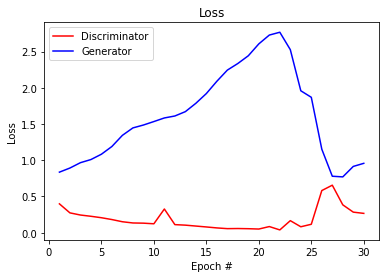

In [ ]:
plot_gan_performance(e_axis, dis_lost, gen_lost, type='Loss')

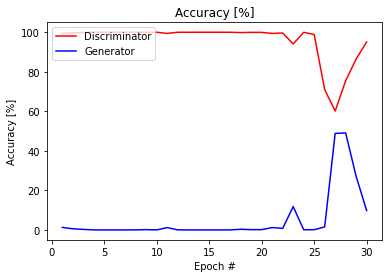

In [ ]:
plot_gan_performance(e_axis, dis_acc, gen_acc, type='Accuracy [%]')

## Bank-full.arff

In [ ]:
generator2 = define_generator(sample_len=real_arr2.shape[1], mid_dense=12,
                              dropout=0.3, name="Generator2")

generator2.summary()

Model: "Generator2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 17)           306         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             multiple             0           dense_3[0][0]                    
                                                                 dense_4[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 12)           216         dropout_1[0][0]         

In [ ]:
discriminator2 = define_discriminator(sample_len=real_arr2.shape[1], dropout=0.3,
                                      name="Discriminator2")

discriminator2.summary()

Model: "Discriminator2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 17)           306         input_8[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 17)           0           dense_21[0][0]                   
                                                                 dense_22[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 17)           306         dropout_7[0][0]     

In [ ]:
gan2 = define_gan(generator2, discriminator2, name="GAN2")

gan2.summary()

Model: "GAN2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator2 (Functional)      (None, 17)                743       
_________________________________________________________________
Discriminator2 (Functional)  (None, 1)                 630       
Total params: 1,373
Trainable params: 1,373
Non-trainable params: 0
_________________________________________________________________


In [ ]:
e_axis, dis_lost, dis_acc, gen_lost, gen_acc, p, generator2, discriminator2, gan2 = \
train(real_arr2, noise_arr2, generator2, discriminator2, gan2, 0.2)

Epoch # | Dis. Loss | Dis. Acc [%] | Gen. Loss | Gen. Acc [%]
--------+-----------+--------------+-----------+-------------
  001   |   0.362   |    98.052    |   0.867   |   3.895
  002   |   0.256   |    99.196    |   0.952   |   1.607
  003   |   0.242   |    99.280    |   1.015   |   1.440
  004   |   0.263   |    98.800    |   1.062   |   2.400
  005   |   0.242   |    98.984    |   1.124   |   1.842
  006   |   0.298   |    97.377    |   1.111   |   3.147
  007   |   0.205   |    98.393    |   1.250   |   2.712
  008   |   0.370   |    85.173    |   1.033   |   28.795
  009   |   0.407   |    92.215    |   1.273   |   15.290
  010   |   0.269   |    92.467    |   1.260   |   7.187
  011   |   0.361   |    88.644    |   0.924   |   8.103
  012   |   0.204   |    95.190    |   1.330   |   9.487
  013   |   0.439   |    85.463    |   0.773   |   19.308
  014   |   0.417   |    84.369    |   0.781   |   11.741
  015   |   0.404   |    92.863    |   0.761   |   11.663
  016   |   0.48

Question 3.a:

In [ ]:
get_indices_of_generated_samples(p, discriminator2, num=3)

3 samples' p's fooled indices:
[6584 4929 7866]
3 samples' p's not fooled indices:
[6060 8579 6205]


In [ ]:
df = convert_n_arr_to_df(p, df2, le2, cols_int_list2)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,62.140724,admin.,97,18,no,17.237392,no,6,21,72.199821,83,0.000000,0.0,0.000000,0.0,98,no
1,931.842651,admin.,1172,primary,no,319.270020,no,no,124,712.738403,1162,0.000000,0.0,0.000000,0.0,1132,no
2,437.889618,admin.,549,primary,no,149.728973,no,no,59,334.536469,545,0.000000,0.0,0.000000,0.0,531,no
3,914.076721,admin.,1149,primary,no,313.172150,no,no,121,699.135681,1140,0.000000,0.0,0.000000,0.0,1110,no
4,82.466560,admin.,divorced,primary,no,1518.121826,no,262,cellular,0.000000,apr,193.462494,0.0,1595.839355,0.0,failure,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8955,343.393738,admin.,430,primary,no,117.294853,no,no,47,262.184387,426,0.000000,0.0,0.000000,0.0,416,no
8956,477.290863,admin.,599,primary,no,163.252777,no,no,64,364.704559,594,0.000000,0.0,0.000000,0.0,579,no
8957,575.766235,admin.,723,primary,no,197.052780,no,no,77,440.103577,717,0.000000,0.0,0.000000,0.0,699,no
8958,811.079224,admin.,1020,primary,no,277.820007,no,no,108,620.274231,1011,0.000000,0.0,0.000000,0.0,985,no


* Examples of samples that "fooled" the detector:

In [ ]:
df.iloc[[6584, 4929, 7866]]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
6584,390.917297,admin.,divorced,primary,no,1097.409912,no,172,cellular,79.975464,apr,0.000000,0.0,1089.060425,0.0,failure,no
4929,0.000000,admin.,divorced,primary,no,1693.059814,no,280,cellular,0.000000,apr,7.594726,0.0,1469.159302,0.0,failure,no
7866,223.188248,admin.,divorced,primary,no,952.599854,no,124,cellular,0.000000,apr,313.631470,0.0,1342.057617,0.0,failure,no


* Examples of samples that did not "fooled" the detector:

In [ ]:
df.iloc[[6060, 8579, 6205]]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
6060,794.108154,admin.,998,primary,no,271.994965,no,no,106,607.280090,990,0.0,0.0,0.0,0.0,964,no
8579,863.023560,admin.,1085,primary,no,295.649017,no,no,115,660.046143,1076,0.0,0.0,0.0,0.0,1048,no
6205,229.116089,admin.,286,primary,no,78.070992,no,no,32,174.686127,284,0.0,0.0,0.0,0.0,277,no


Question 3.b:

In [ ]:
n = randint(0, noise_arr2.shape[0], 100)
n

array([36009, 15519, 16813, 19870, 29413, 10898, 27702, 13535,  5668,
       19940, 36403,  1163, 41188, 36859, 43539, 29919, 28999, 28393,
       34754,  2324, 42432, 15746,  9842, 25059, 39046,  5832,  9392,
       31546, 38412, 32119, 28676, 13969, 29052, 17705, 22405,  3169,
        7945, 11160, 38450, 43930, 38450, 32961, 37931, 33981, 20953,
       40412, 35262, 12932, 41254, 10596, 31914, 25892,  2322, 24697,
       27375,  2351, 10721, 11199, 15999,  1554, 35920, 44695, 26360,
       28895, 42786, 15042, 15517, 22115, 35881, 10695,   923,  4798,
       16546,   571, 37881, 21951, 35683,   462, 15801,  8813, 33784,
       25313, 31482, 17813, 13059,  6048, 35769,  8895, 16794, 23580,
       29551, 38804,  8687, 14210, 42700, 15079, 18353,  6746, 15692,
       41641])

In [ ]:
y = np.rint(gan2(noise_arr2[n]))
(y == 1).sum()

10

Question 3.c:

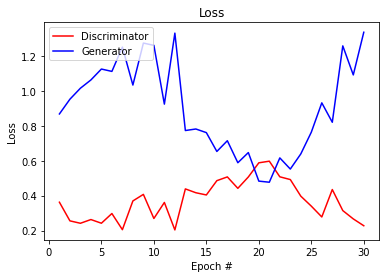

In [ ]:
plot_gan_performance(e_axis, dis_lost, gen_lost, type='Loss')

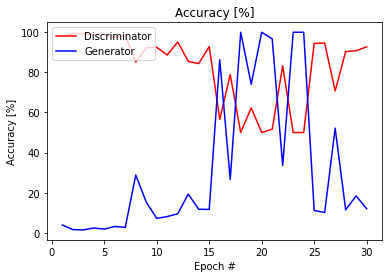

In [ ]:
plot_gan_performance(e_axis, dis_acc, gen_acc, type='Accuracy [%]')

#3. General Generative Model for Sample Generation

##3.1 Training Black-Box Model (Random Forest) on the Datasets

In [ ]:
test_size = 0.1

In [ ]:
n = 120

###Adult.arff

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = \
train_test_split(real_arr1[:, :14], real_arr1[:, 14], test_size=test_size)

In [ ]:
rf1 = RandomForestClassifier(n_estimators=n)

In [ ]:
rf1.fit(X_train_1, y_train_1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(f"Random Forest accuracy score on test: {rf1.score(X_test_1, y_test_1)*100:.3f}%")

Random Forest accuracy score on test: 85.438%


In [ ]:
rf1.predict(X_test_1)

array([0., 0., 1., ..., 1., 1., 0.])

In [ ]:
cs1 = rf1.predict_proba(X_test_1)
cs1

array([[0.99166667, 0.00833333],
       [0.70833333, 0.29166667],
       [0.31666667, 0.68333333],
       ...,
       [0.00833333, 0.99166667],
       [0.        , 1.        ],
       [1.        , 0.        ]])

In [ ]:
cs1_max = cs1.max(axis=1)
cs1_min = cs1.min(axis=1)
cs1_max, cs1_min

(array([0.99166667, 0.70833333, 0.68333333, ..., 0.99166667, 1.        ,
        1.        ]),
 array([0.00833333, 0.29166667, 0.31666667, ..., 0.00833333, 0.        ,
        0.        ]))

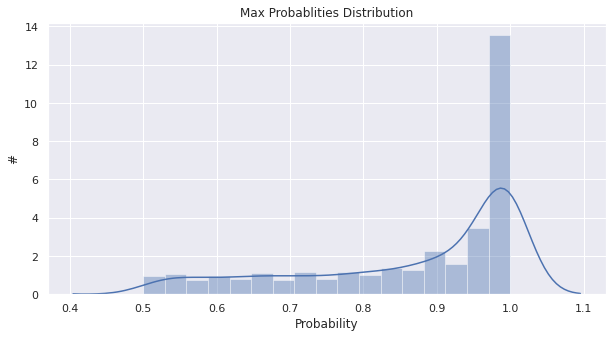

In [ ]:
plot_dist(cs1_max, "Max")

In [ ]:
print_statistics(cs1_max, "Max")

Max Probabilities statistics: Max = 1.000, Min = 0.500, Average = 0.867


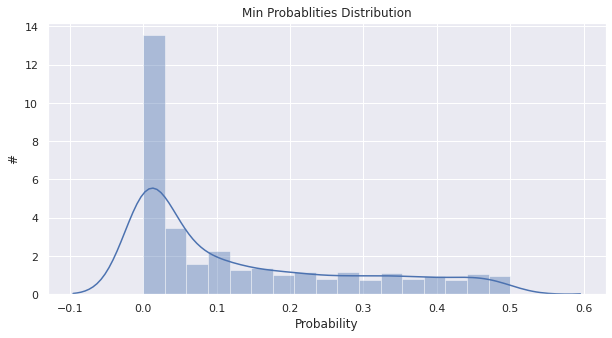

In [ ]:
plot_dist(cs1_min, "Min")

In [ ]:
print_statistics(cs1_min, "Min")

Min Probabilities statistics: Max = 0.500, Min = 0.000, Average = 0.133


###Bank-full.arff

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = \
train_test_split(real_arr2[:, :16], real_arr2[:, 16], test_size=test_size)

In [ ]:
rf2 = RandomForestClassifier(n_estimators=n)

In [ ]:
rf2.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(f"Random Forest accuracy score on test: {rf2.score(X_test_2, y_test_2)*100:.3f}%")

Random Forest accuracy score on test: 90.826%


In [ ]:
rf2.predict(X_test_2)

array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:
cs2 = rf2.predict_proba(X_test_2)
cs2

array([[1.        , 0.        ],
       [0.3       , 0.7       ],
       [0.98333333, 0.01666667],
       ...,
       [1.        , 0.        ],
       [0.99166667, 0.00833333],
       [0.88333333, 0.11666667]])

In [ ]:
cs2_max = cs2.max(axis=1)
cs2_min = cs2.min(axis=1)
cs2_max, cs2_min

(array([1.        , 0.7       , 0.98333333, ..., 1.        , 0.99166667,
        0.88333333]),
 array([0.        , 0.3       , 0.01666667, ..., 0.        , 0.00833333,
        0.11666667]))

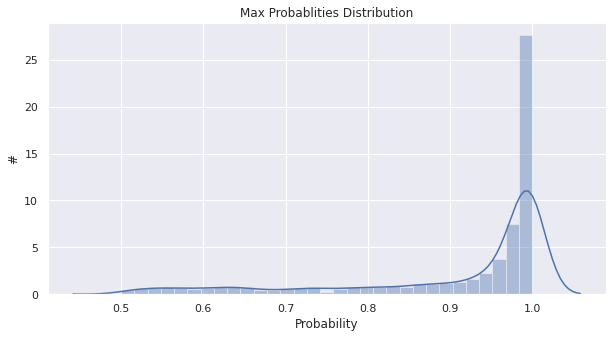

In [ ]:
plot_dist(cs2_max, "Max")

In [ ]:
print_statistics(cs2_max, "Max")

Max Probabilities statistics: Max = 1.000, Min = 0.500, Average = 0.907


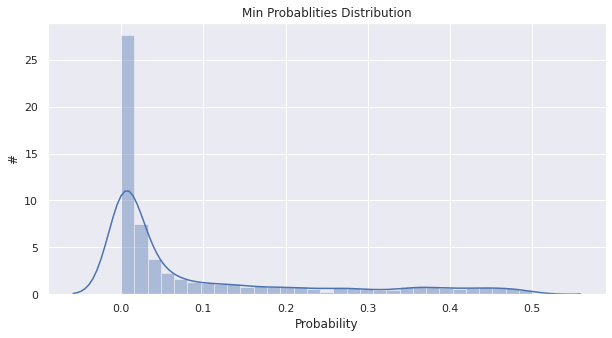

In [ ]:
plot_dist(cs2_min, "Min")

In [ ]:
print_statistics(cs2_min, "Min")

Min Probabilities statistics: Max = 0.500, Min = 0.000, Average = 0.093


##3.2 Training Generative Model

###Adult.arff

In [ ]:
generator11 = define_generative_generator(sample_len=real_arr1.shape[1], mid_dense=10, 
                                         dropout=0.3, name="Generative_Generator11")

generator11.summary()

Model: "Generative_Generator11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 15)           240         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               multiple             0           dense[0][0]                      
                                                                 dense_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           160         dropout[0][0

In [ ]:
des_conf1 = uniform(0, 1, noise_arr1.shape[0])
des_conf1, des_conf1.shape

(array([0.58101847, 0.26550001, 0.02507264, ..., 0.56953945, 0.87149935,
        0.35860117]), (32000,))

In [ ]:
e_axis1, gen_lost1, gen_acc1, generator11 = \
train_generative(noise_arr1, des_conf1, generator11, black_box=rf1, val_split=0.2)

Epoch # | Gen. Loss | Gen. Acc [%]
--------+-----------+-------------
  001   |   36094488.000   |   89.125
  002   |   143926.891   |   65.344
  003   |   22350.074   |   4.219
  004   |   7483.463   |   2.812
  005   |   695.360   |   1.438


In [ ]:
p1 = generator11.predict(noise_arr1[:1000])
p1, p1.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), (1000, 14))

In [ ]:
cs11 = rf1.predict_proba(p1)
cs11, cs11.shape

(array([[0.86666667, 0.13333333],
        [0.86666667, 0.13333333],
        [0.86666667, 0.13333333],
        ...,
        [0.86666667, 0.13333333],
        [0.86666667, 0.13333333],
        [0.86666667, 0.13333333]]), (1000, 2))

In [ ]:
cs111 = rf1.predict(p1)
cs111

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
cs11_max = cs11.max(axis=1)
cs11_min = cs11.min(axis=1)
cs11_max, cs11_min, cs11_max.shape, cs11_min.shape

(array([0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.85      , 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.85      , 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
        0.86666667, 0.86666667, 0.86666667, 0.86

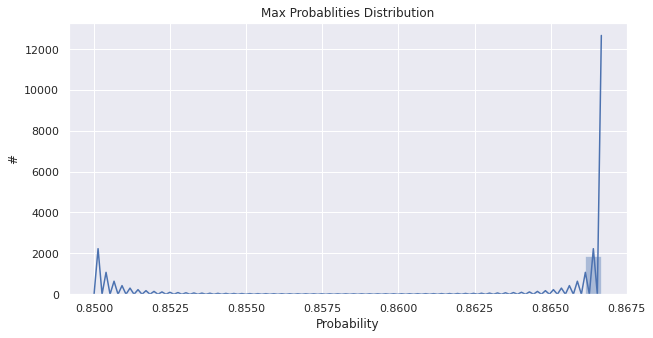

In [ ]:
plot_dist(cs11_max, "Max")

In [ ]:
print_statistics(cs11_max, "Max")

Max Probabilities statistics: Max = 0.867, Min = 0.850, Average = 0.867


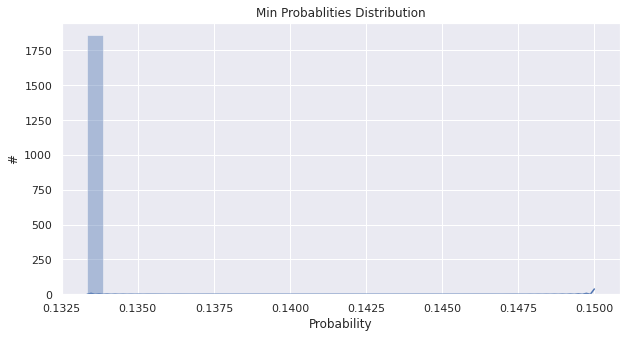

In [ ]:
plot_dist(cs11_min, "Min")

In [ ]:
print_statistics(cs11_min, "Min")

Min Probabilities statistics: Max = 0.150, Min = 0.133, Average = 0.133


In [ ]:
loss_vector1 = get_loss_vector(noise_arr = noise_arr1[:1000], 
                              des_conf = des_conf1[:1000], 
                              generator = generator11, 
                              black_box = rf1)

loss_vector1, loss_vector1.shape

(array([2.85648194e-01, 6.01166654e-01, 8.41594028e-01, 2.02307593e-01,
        7.09563313e-01, 7.54040224e-01, 1.60547864e-01, 1.68023929e-02,
        6.68584835e-01, 8.05258798e-01, 4.53039848e-01, 7.18728663e-01,
        7.12747022e-01, 6.26485264e-01, 7.05574415e-01, 2.90863572e-01,
        2.56894437e-01, 1.76278724e-02, 7.29390236e-01, 1.37680309e-02,
        6.67654033e-01, 4.53367508e-01, 4.97368542e-01, 7.61362683e-02,
        6.46266461e-01, 4.46959140e-01, 5.17005744e-01, 6.49857001e-01,
        7.98405265e-01, 3.14666188e-01, 7.19967879e-01, 6.43464749e-01,
        6.42229244e-01, 2.71264104e-01, 7.63603797e-01, 8.36992200e-01,
        4.55621340e-01, 3.79964097e-01, 5.32928333e-01, 7.50363176e-01,
        7.95599962e-01, 1.45218988e-02, 2.40644587e-01, 5.85660305e-01,
        9.45938547e-02, 6.39219080e-01, 1.26225007e-01, 3.21369294e-01,
        1.27309311e-01, 4.24089763e-02, 8.33139944e-01, 4.93264328e-01,
        8.33646717e-02, 7.78233095e-01, 3.49629279e-01, 5.343964

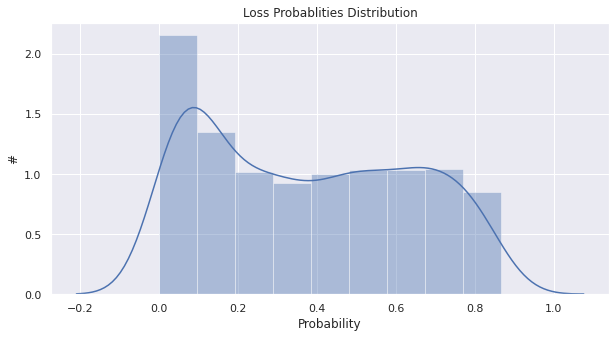

In [ ]:
plot_dist(loss_vector1, "Loss")

###Bank-full.arff

In [ ]:
generator22 = define_generative_generator(sample_len=real_arr2.shape[1], mid_dense=10, 
                                         dropout=0.3, name="Generative_Generator22")

generator22.summary()

Model: "Generative_Generator22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 17)           306         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             multiple             0           dense_3[0][0]                    
                                                                 dense_4[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 10)           180         dropout_1[0]

In [ ]:
des_conf2 = uniform(0, 1, noise_arr2.shape[0])
des_conf2, des_conf2.shape

(array([0.92410908, 0.13822018, 0.67773108, ..., 0.99237805, 0.80468708,
        0.26587335]), (44800,))

In [ ]:
e_axis2, gen_lost2, gen_acc2, generator22 = \
train_generative(noise_arr2, des_conf2, generator22, black_box=rf2, val_split=0.2)

Epoch # | Gen. Loss | Gen. Acc [%]
--------+-----------+-------------
  001   |   1179.951   |   3.248
  002   |   34.984   |   5.324
  003   |   11.937   |   1.138
  004   |   0.365   |   1.027
  005   |   1.435   |   1.127


In [ ]:
p2 = generator22.predict(noise_arr2[:1000])
p2, p2.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), (1000, 16))

In [ ]:
cs22 = rf2.predict_proba(p2)
cs22, cs22.shape

(array([[0.76666667, 0.23333333],
        [0.76666667, 0.23333333],
        [0.76666667, 0.23333333],
        ...,
        [0.76666667, 0.23333333],
        [0.76666667, 0.23333333],
        [0.76666667, 0.23333333]]), (1000, 2))

In [ ]:
cs222 = rf2.predict(p2)
cs222

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
cs22_max = cs22.max(axis=1)
cs22_min = cs22.min(axis=1)
cs22_max, cs22_min, cs22_max.shape, cs22_min.shape

(array([0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76666667, 0.76666667,
        0.76666667, 0.76666667, 0.76666667, 0.76

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


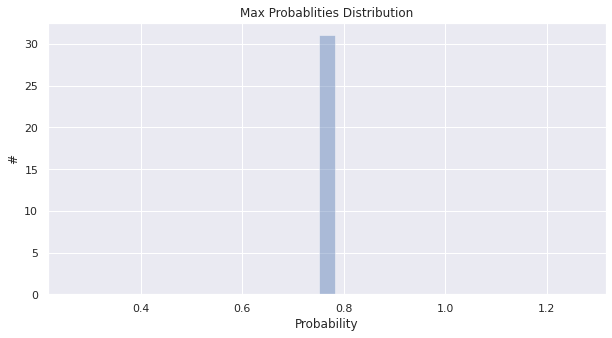

In [ ]:
plot_dist(cs22_max, "Max")

In [ ]:
print_statistics(cs22_max, "Max")

Max Probabilities statistics: Max = 0.767, Min = 0.767, Average = 0.767


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


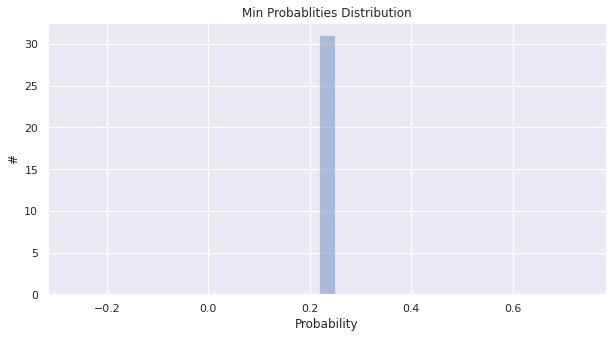

In [ ]:
plot_dist(cs22_min, "Min")

In [ ]:
print_statistics(cs22_min, "Min")

Min Probabilities statistics: Max = 0.233, Min = 0.233, Average = 0.233


In [ ]:
loss_vector2 = get_loss_vector(noise_arr = noise_arr2[:1000], 
                              des_conf = des_conf2[:1000], 
                              generator = generator22, 
                              black_box = rf2)

loss_vector2, loss_vector2.shape

(array([1.57442413e-01, 6.28446489e-01, 8.89355891e-02, 6.76516620e-03,
        5.19514530e-01, 1.67920066e-01, 4.24924232e-01, 2.62649324e-01,
        5.26804880e-01, 2.73060965e-01, 6.04997287e-01, 5.34533809e-01,
        4.59080951e-01, 3.04817628e-01, 5.75104557e-01, 7.24277477e-02,
        3.18838271e-02, 2.00516325e-02, 8.94188322e-02, 6.81793869e-01,
        5.60869794e-02, 7.66333636e-01, 4.85953637e-03, 6.82196904e-01,
        7.31963215e-02, 2.06141726e-01, 6.82911646e-01, 1.48776206e-01,
        7.61100376e-01, 1.81878996e-01, 2.71894583e-01, 4.48244231e-01,
        3.97559863e-01, 5.18869641e-02, 1.40580186e-01, 9.12672758e-02,
        5.67713923e-01, 1.18569020e-01, 2.93929247e-01, 5.18334890e-01,
        1.32878138e-01, 3.53485140e-01, 2.79528158e-01, 3.17953469e-01,
        2.39137198e-01, 1.08814531e-01, 1.92336677e-02, 2.12063990e-01,
        1.62647152e-01, 1.44394168e-01, 1.66540894e-01, 2.86562518e-01,
        4.68042518e-01, 1.77243249e-01, 6.60624874e-01, 1.402866

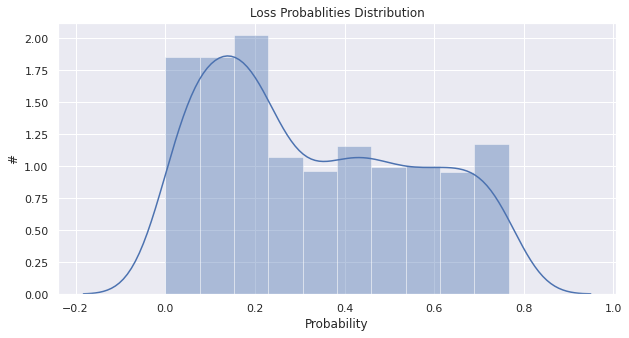

In [ ]:
plot_dist(loss_vector2, "Loss")